__детектор объектов на изображении__

Евгений Борисов esborisov@sevsu.ru

Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks   
Shaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun   
6 Jan 2016   
    
https://arxiv.org/pdf/1506.01497.pdf

In [1]:
import os
import numpy as np
from numpy import random as rng
from PIL import Image
from PIL import ImageDraw
from matplotlib import pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

---

In [3]:
# подгружаем предобученую модель faster-r-cnn

from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=True) 
model = model.train(mode=False)

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

---

In [5]:
img_folder = '../data/pascal'
files = os.listdir(img_folder)

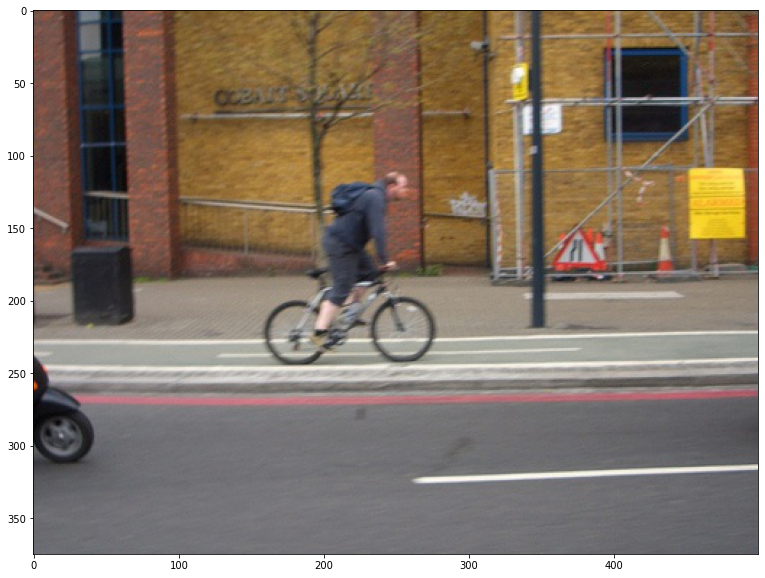

In [97]:
# выбираем случайное фото
f = rng.choice(files)
img = Image.open(os.path.join(img_folder,f))
# img
plt.figure(figsize=(15,10))
plt.imshow(img)

In [98]:
x = transforms.ToTensor()(img).unsqueeze(dim=0) # преобразуем фото в torch.tensor
with torch.no_grad():  # отключаем расчёт градиента
    o = model(x)  # считаем выход модели

In [99]:
# извлекаем результаты
boxes = o[0]['boxes'].detach().numpy() # рамки объектов
scores = o[0]['scores'].detach().numpy() # скор класса-результата
labels = o[0]['labels'].detach().numpy() # метка класса

# формируем имя объекта со скором
text = [ 
    '%s %.2f'%( COCO_INSTANCE_CATEGORY_NAMES[labels[n]],scores[n] )
    for n in range(len(labels))
    ]

In [100]:
# основной список цветов для рисования рамок объектов
colors = rng.permutation(['blue', 'green', 'orange', 'red', 'lightseagreen',]).tolist()

classes_idx = sorted( set(labels) ) # список меток обнаруженных классов 
# если классов больше чем базовых цветов то дополняем список цветов
s = len(classes_idx)-len(colors)
colors += [] if(s<1) else ['coral']*s

# назначаем цвета классов
colors = { classes_idx[n]:colors[n] for n in range(len(classes_idx)) }

bicycle 1.00
person 1.00
motorcycle 0.98
backpack 0.98


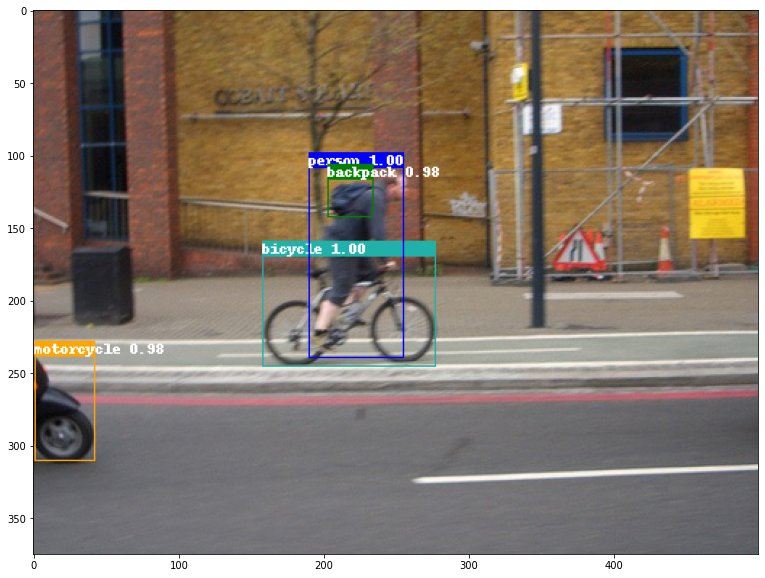

In [101]:
# рисуем результат

res = img.copy()
res_draw = ImageDraw.Draw(res)

for n in range(len(labels)): # для всех найденых объектов
    if scores[n]<0.7:continue # выкидываем объекты с низким скором
    fx0,fy0,fx1,fy1 = boxes[n,:].tolist() # координаты углов рамки объекта
    clr = colors[labels[n]] # цвет класса
    res_draw.rectangle( (fx0,fy0,fx1,fy1), outline=clr ) # рисуем рамку
    # подписываем
    tfp = fx0,fy0,fx1,fy0-10   # координаты рамки заголовка
    res_draw.rectangle(tfp,fill=clr)
    tx,ty = fx0,fy0-10 # координаты подписи
    res_draw.text((tx,ty),text[n],fill='white')
        
    print(text[n])

plt.figure(figsize=(15,10))
plt.imshow(res)